# A/B-тестирование

### Постановка задачи

<b>Цель</b> — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
<b>Задачи:</b>
- Оцените корректность проведения теста
- Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, проверьте:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Данные

[final_ab_events.csv](https://disk.yandex.ru/d/pgKgZ9lRp0Enwg)

[ab_project_marketing_events.csv](https://disk.yandex.ru/d/ZVC7GUYYckKnGQ)

[final_ab_new_users.csv](https://disk.yandex.ru/d/Qrto8Gerpu424g)

[final_ab_participants.csv](https://disk.yandex.ru/d/nhGUR3ZkNIG4VA)

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

### Как сделать задание?

- Опишите цели исследования
- Исследуйте данные:
    - Требуется ли преобразование типов?
    - Опишите природу пропущенных значений и дубликатов, если их обнаружите.
- Оцените корректность проведения теста. Обратите внимание на:
    - Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.
    - Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования.
- Проведите исследовательский анализ данных:
    - Количество событий на пользователя одинаково распределены в выборках?
    - Как число событий в выборках распределено по дням?
    - Как меняется конверсия в воронке в выборках на разных этапах?
    - Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
- Оцените результаты A/B-тестирования
    - Что можно сказать про результаты A/В-тестирования?
    - Проверьте статистическую разницу долей z-критерием.
- Опишите выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделайте общее заключение о корректности проведения теста.

In [641]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
from scipy import stats as st
pd.options.display.max_colwidth = 210

In [642]:
server_path = 'datasets/'
local_path = '/datasets/'

files = [
    'final_ab_events.csv',
    'ab_project_marketing_events.csv',
    'final_ab_new_users.csv',
    'final_ab_participants.csv'
    ]

datasets = []

for file in files:
    try:
        datasets.append(pd.read_csv(server_path + file))
    except FileNotFoundError:
        datasets.append(pd.read_csv(local_path + file))

df_final_ab_events = datasets[0]
df_ab_project_marketing_events = datasets[1]
df_final_ab_new_users = datasets[2]
df_final_ab_participants = datasets[3]

## Проверка данных

In [643]:
df_final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [644]:
df_final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [645]:
df_ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [646]:
df_ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [647]:
df_final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [648]:
df_final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [649]:
df_final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [650]:
df_final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Вывод: из полученных данных видно, что необходимо привести к типу данных дате, след столбцы: event_dt, start_dt, finish_dt, first_date

In [651]:
df_final_ab_events['event_dt'] = pd.to_datetime(df_final_ab_events['event_dt'])
df_final_ab_events['event_dt_t0'] = pd.to_datetime(df_final_ab_events['event_dt']).dt.date.astype('datetime64[ns]')
df_ab_project_marketing_events['start_dt'] = pd.to_datetime(df_ab_project_marketing_events['start_dt'], infer_datetime_format=True)
df_ab_project_marketing_events['finish_dt'] = pd.to_datetime(df_ab_project_marketing_events['finish_dt'], infer_datetime_format=True)
df_final_ab_new_users['first_date'] = pd.to_datetime(df_final_ab_new_users['first_date'], infer_datetime_format=True)

In [652]:
df_final_ab_events.head()

,user_id,event_dt,event_name,details,event_dt_t0
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


In [653]:
df_ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [654]:
df_final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [655]:
df_final_ab_events.isnull().sum()

user_id             0
event_dt            0
event_name          0
details        377577
event_dt_t0         0
dtype: int64

In [656]:
df_ab_project_marketing_events.isnull().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [657]:
df_final_ab_new_users.isnull().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [658]:
df_final_ab_participants.isnull().sum()

user_id    0
group      0
ab_test    0
dtype: int64

Вывод: пропуски были обнаруженны в df_final_ab_events. Такое огромное кол-во пропусков в данном столбце обосновано тем, что не к каждому событию добаляется доп. информация. Ничего с этими пропусками делать не будем.

In [659]:
df_final_ab_events.duplicated().sum()

0

In [660]:
df_ab_project_marketing_events.duplicated().sum()

0

In [661]:
df_final_ab_new_users.duplicated().sum()

0

In [662]:
df_final_ab_participants.duplicated().sum()

0

Вывод: явных дубликатов не обнаруженно

### Проверка не попадают ли у нас пользователи в обе группы

In [663]:
df_final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [664]:
df_final_ab_participants_A = df_final_ab_participants[df_final_ab_participants['group'] == 'A']
df_final_ab_participants_B = df_final_ab_participants[df_final_ab_participants['group'] == 'B']
print(len(df_final_ab_participants_A), len(df_final_ab_participants_B))
df_final_ab_participants_A['user_id'].isin(df_final_ab_participants_B['user_id']).value_counts ()

9655 8613


False    8879
True      776
Name: user_id, dtype: int64

Вывод: как видино, 776 пользователей попали в обе групппы. Далее уберем этих пользователей из групп

In [665]:
df_final_ab_participants_clear = pd.merge(df_final_ab_participants_A, df_final_ab_participants_B, on=['user_id'], how='inner')
df_final_ab_participants_clear

,user_id,group_x,ab_test_x,group_y,ab_test_y
0,FC3F3E4DA7C85F88,A,recommender_system_test,B,interface_eu_test
1,FE2AF0E94DBD470E,A,recommender_system_test,B,interface_eu_test
2,C5AD06762E628169,A,recommender_system_test,B,interface_eu_test
3,25CE0629AC6B6971,A,recommender_system_test,B,interface_eu_test
4,44EB15AD423DC31C,A,recommender_system_test,B,interface_eu_test
...,...,...,...,...,...
771,54C70FDA087B74AC,A,interface_eu_test,B,recommender_system_test
772,50509A01096B2B14,A,interface_eu_test,B,recommender_system_test
773,CA6F4DAED160E5B1,A,interface_eu_test,B,recommender_system_test
774,C70DF942E542DA69,A,interface_eu_test,B,recommender_system_test


In [666]:
print(len(df_final_ab_participants))
df_final_ab_participants = df_final_ab_participants.loc[~((df_final_ab_participants.user_id.isin(df_final_ab_participants_clear['user_id']))),:]
print(len(df_final_ab_participants))

18268
16716


In [667]:
df_final_ab_participants_A = df_final_ab_participants[df_final_ab_participants['group'] == 'A']
df_final_ab_participants_B = df_final_ab_participants[df_final_ab_participants['group'] == 'B']
print(len(df_final_ab_participants_A), len(df_final_ab_participants_B))
df_final_ab_participants_A['user_id'].isin(df_final_ab_participants_B['user_id']).value_counts ()

8879 7837


False    8879
Name: user_id, dtype: int64

### За какой период нам доступны данные (даты начала и окончания теста)

In [668]:
print(df_final_ab_events.groupby('user_id')['event_dt'].min().reset_index()['event_dt'].min())
print(df_final_ab_events.groupby('user_id')['event_dt'].max().reset_index()['event_dt'].max())

2020-12-07 00:00:33
2020-12-30 23:36:33


### Сколько у нас уникальных групп и количество пользователей в каждой

In [669]:
print('Уникальных групп:', df_final_ab_participants['group'].nunique())

Уникальных групп: 2


In [670]:
print('A:', len(df_final_ab_participants_A), 'B:', len(df_final_ab_participants_B))

A: 8879 B: 7837


## Часть 1. Анализ A/B-теста

### Оценка корректность проведения теста.
Обратите внимание на:
    - Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.
    - Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования.

#### Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

In [671]:
print(f"Названия тестов: {df_final_ab_participants['ab_test'].unique()}")

Названия тестов: ['recommender_system_test' 'interface_eu_test']


In [672]:
print(f"Кол-во групп: {df_final_ab_participants['group'].nunique()}, группы: {df_final_ab_participants['group'].unique()}")

Кол-во групп: 2, группы: ['A' 'B']


In [673]:
print(f"дата запуска(2020-12-07): {df_final_ab_new_users.groupby('user_id')['first_date'].min().reset_index()['first_date'].min()}")
print(f"дата остановки набора новых пользователей(2020-12-21): {df_final_ab_new_users.groupby('user_id')['first_date'].min().reset_index()['first_date'].max()}")

дата запуска(2020-12-07): 2020-12-07 00:00:00
дата остановки набора новых пользователей(2020-12-21): 2020-12-23 00:00:00


Вывод: из данных видно, что дата остановки набора пользователей не сходиться и оканчивается позже, но т.к. в базе результаты двух тестов, то нужно проверить к какому тесту относятся пользователи, которые превысили дату.

In [674]:
df_final_ab_participants_A0 = df_final_ab_new_users[(df_final_ab_new_users['first_date'] > '2020-12-21')]
df_final_ab_participants_A1 = df_final_ab_participants[(df_final_ab_participants['group'] == 'A')&(df_final_ab_participants['ab_test'] == 'recommender_system_test')]
print(len(df_final_ab_participants_A0), len(df_final_ab_participants_A1))
df_final_ab_participants_A0['user_id'].isin(df_final_ab_participants_A1['user_id']).value_counts()

5263 3385


False    5263
Name: user_id, dtype: int64

In [675]:
df_final_ab_participants_A0 = df_final_ab_new_users[(df_final_ab_new_users['first_date'] > '2020-12-21')]
df_final_ab_participants_A1 = df_final_ab_participants[(df_final_ab_participants['group'] == 'A')&(df_final_ab_participants['ab_test'] == 'interface_eu_test')]
print(len(df_final_ab_participants_A0), len(df_final_ab_participants_A1))
df_final_ab_participants_A0['user_id'].isin(df_final_ab_participants_A1['user_id']).value_counts()

5263 5494


False    4774
True      489
Name: user_id, dtype: int64

Вывод: как видим это пользователи из другого теста попали в выборку.

In [676]:
print(f"дата остановки (2021-01-04): {df_final_ab_events.groupby('user_id')['event_dt'].min().reset_index()['event_dt'].max()}")

дата остановки (2021-01-04): 2020-12-29 09:03:53


Вывод: данные по действиям пользователя не превышают дату остановки теста, но стоит обратить внимание, что по 29.12 не было совершенно ни одного действия

In [677]:
print(f"аудитория: 15% новых пользователей из региона EU: {(len(df_final_ab_new_users[df_final_ab_new_users['region'] == 'EU']) / len(df_final_ab_new_users))*100}%")

аудитория: 15% новых пользователей из региона EU: 74.9518085950788%


Вывод: как мы видим из полученных данных, всё совсем наоборот, большую часть составляют пользователи из EU

In [678]:
print(f"назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы {df_final_ab_participants['ab_test'].unique()}")

назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы ['recommender_system_test' 'interface_eu_test']


Вывод: видно, что в списке есть еще один тест.

In [679]:
print(f"ожидаемое количество участников теста: 6000 {df_final_ab_participants['user_id'].nunique()}")

ожидаемое количество участников теста: 6000 15890


Вывод: кол-во участников превышенно в 2,5 раза

- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

In [680]:
a = len(df_final_ab_events[(df_final_ab_events['event_dt_t0'] == '2020-12-07')&(df_final_ab_events['event_name'] == 'product_page')]) / df_final_ab_events['user_id'].nunique() * 100
b = len(df_final_ab_events[(df_final_ab_events['event_dt_t0'] == '2020-12-29')&(df_final_ab_events['event_name'] == 'product_page')]) / df_final_ab_events['user_id'].nunique() * 100
print(f"конверсии в просмотр карточек товаров — событие product_page {a/b -1}")

конверсии в просмотр карточек товаров — событие product_page 0.1281337047353759


In [681]:
a = len(df_final_ab_events[(df_final_ab_events['event_dt_t0'] == '2020-12-07')&(df_final_ab_events['event_name'] == 'product_cart')]) / df_final_ab_events['user_id'].nunique() * 100
b = len(df_final_ab_events[(df_final_ab_events['event_dt_t0'] == '2020-12-29')&(df_final_ab_events['event_name'] == 'product_cart')]) / df_final_ab_events['user_id'].nunique() * 100
print(f"просмотры корзины — `product_cart` {a/b -1}")

просмотры корзины — `product_cart` 0.08133971291866016


In [682]:
a = len(df_final_ab_events[(df_final_ab_events['event_dt_t0'] == '2020-12-07')&(df_final_ab_events['event_name'] == 'purchase')]) / df_final_ab_events['user_id'].nunique() * 100
b = len(df_final_ab_events[(df_final_ab_events['event_dt_t0'] == '2020-12-29')&(df_final_ab_events['event_name'] == 'purchase')]) / df_final_ab_events['user_id'].nunique() * 100
print(f"покупки — `purchase` {a/b -1}")

покупки — `purchase` 0.1587078651685394


Вывод: из полученных данных видно, что конверсия по двум показателям улучшиласть не менее, чем на 10%, но Просмотры корзины не дотянули и составили 8%

### Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.

In [683]:
df_ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [684]:
df_ab_project_marketing_events[(df_ab_project_marketing_events['start_dt'] >= '2020-12-07') & (df_ab_project_marketing_events['start_dt'] <= '2021-01-04')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Вывод: как видно из полученнных данных, две маркетенговые компании попадают на время проведения теста.

### Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования

In [685]:
df_final_ab_participants_A_rec = df_final_ab_participants[(df_final_ab_participants['group'] == 'A')&(df_final_ab_participants['ab_test'] == 'recommender_system_test')]
df_final_ab_participants_A_int = df_final_ab_participants[(df_final_ab_participants['group'] == 'A')&(df_final_ab_participants['ab_test'] == 'interface_eu_test')]
print(len(df_final_ab_participants_A_rec), len(df_final_ab_participants_A_int))
df_final_ab_participants_A_rec['user_id'].isin(df_final_ab_participants_A_int['user_id']).value_counts ()

3385 5494


False    2903
True      482
Name: user_id, dtype: int64

In [686]:
df_final_ab_participants_B_rec = df_final_ab_participants[(df_final_ab_participants['group'] == 'B')&(df_final_ab_participants['ab_test'] == 'recommender_system_test')]
df_final_ab_participants_B_int = df_final_ab_participants[(df_final_ab_participants['group'] == 'B')&(df_final_ab_participants['ab_test'] == 'interface_eu_test')]
print(len(df_final_ab_participants_B_rec), len(df_final_ab_participants_B_int))
df_final_ab_participants_B_rec['user_id'].isin(df_final_ab_participants_B_int['user_id']).value_counts ()

2540 5297


False    2196
True      344
Name: user_id, dtype: int64

In [687]:
df_final_ab_participants_A = df_final_ab_participants[df_final_ab_participants['group'] == 'A']
df_final_ab_participants_B = df_final_ab_participants[df_final_ab_participants['group'] == 'B']

In [688]:
print(len(df_final_ab_participants_A), len(df_final_ab_participants_B), len(df_final_ab_participants_A)/len(df_final_ab_participants_B) - 1)
df_final_ab_participants_A['user_id'].isin(df_final_ab_participants_B['user_id']).value_counts ()

8879 7837 0.1329590404491514


False    8879
Name: user_id, dtype: int64

Вывод: как видно из полученных данных, в выборке А - 482 пользователя пересекаются, а в выборке В - 344. Кол-во участников в группе В на 13% меньше, чем в А. Так же выше уже было отмечено, что в группу А и В попали одни и те же пользователи.

## Проведите исследовательский анализ данных:
- Количество событий на пользователя одинаково распределены в выборках?
- Как число событий в выборках распределено по дням?
- Как меняется конверсия в воронке в выборках на разных этапах?
- Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

### Количество событий на пользователя одинаково распределены в выборках?

array([[<AxesSubplot:title={'center':'event_name'}>]], dtype=object)

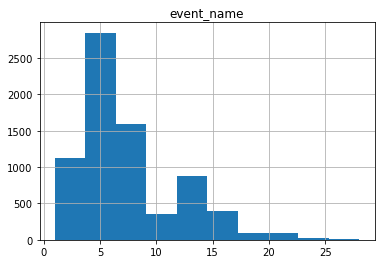

In [689]:
df_final_ab_events[df_final_ab_events['user_id'].isin(df_final_ab_participants_A['user_id'])].groupby(['user_id'])['event_name'].count().reset_index().hist()

In [690]:
df_ab_user_a = df_final_ab_events[df_final_ab_events['user_id'].isin(df_final_ab_participants_A['user_id'])].groupby(['user_id'])['event_name'].count().to_frame().reset_index()
alpha = .05

results = st.shapiro(df_ab_user_a.event_name)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')


p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


/Users/aleksandr/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


array([[<AxesSubplot:title={'center':'event_name'}>]], dtype=object)

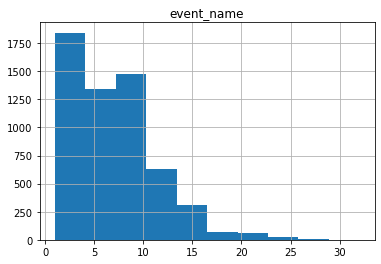

In [691]:
df_final_ab_events[df_final_ab_events['user_id'].isin(df_final_ab_participants_B['user_id'])].groupby(['user_id'])['event_name'].count().reset_index().hist()

In [692]:
df_ab_user_b = df_final_ab_events[df_final_ab_events['user_id'].isin(df_final_ab_participants_B['user_id'])].groupby(['user_id'])['event_name'].count().to_frame().reset_index()
alpha = .05

results = st.shapiro(df_ab_user_b.event_name)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


In [693]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(df_ab_user_a.event_name, df_ab_user_b.event_name)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.012100883183766113
Отвергаем нулевую гипотезу: разница статистически значима


### Как число событий в выборках распределено по дням?

<AxesSubplot:>

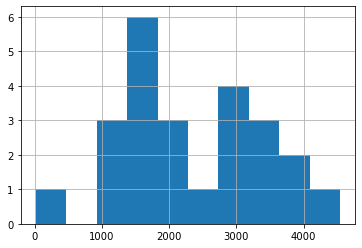

In [694]:
df_final_ab_events[df_final_ab_events['user_id'].isin(df_final_ab_participants_A['user_id'])].groupby(['event_dt_t0'])['event_name'].count().hist()

In [695]:
df_ab_date_a = df_final_ab_events[df_final_ab_events['user_id'].isin(df_final_ab_participants_A['user_id'])].groupby(['event_dt_t0'])['event_name'].count().to_frame().reset_index()
alpha = .05

results = st.shapiro(df_ab_date_a.event_name)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.510229229927063
Не получилось отвергнуть нулевую гипотезу, всё нормально


<AxesSubplot:>

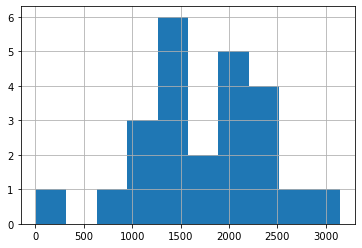

In [696]:
df_final_ab_events[df_final_ab_events['user_id'].isin(df_final_ab_participants_B['user_id'])].groupby(['event_dt_t0'])['event_name'].count().hist()

In [697]:
df_ab_date_b = df_final_ab_events[df_final_ab_events['user_id'].isin(df_final_ab_participants_B['user_id'])].groupby(['event_dt_t0'])['event_name'].count().to_frame().reset_index()
alpha = .05

results = st.shapiro(df_ab_date_b.event_name)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.6776079535484314
Не получилось отвергнуть нулевую гипотезу, всё нормально


In [698]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(df_ab_date_a.event_name, df_ab_date_b.event_name)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.052586640271858456
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Вывод: как видно из полученных данных, Количество событий на пользователя одинаково распределены - не нормально, а число событий в выборках распределено по дням - нормально.

### Как меняется конверсия в воронке в выборках на разных этапах?

In [757]:
df_final_ab_events_gr = df_final_ab_events.groupby(['user_id', 'event_dt_t0'])['details'].agg(['sum', 'count'])
df_final_ab_events_gr = df_final_ab_events_gr.reset_index()

df_final_ab_events_gr

,user_id,event_dt_t0,sum,count
0,0001710F4DDB1D1B,2020-12-14,0.00,0
1,0001710F4DDB1D1B,2020-12-15,0.00,0
2,000199F1887AE5E6,2020-12-14,4.99,1
3,000199F1887AE5E6,2020-12-15,4.99,1
4,000199F1887AE5E6,2020-12-20,4.99,1
...,...,...,...,...
189714,FFFAB034A09DCC28,2020-12-18,0.00,0
189715,FFFAB034A09DCC28,2020-12-21,0.00,0
189716,FFFFE36C0F6E92DF,2020-12-22,0.00,0
189717,FFFFE36C0F6E92DF,2020-12-23,0.00,0


In [758]:
df_all_a = df_final_ab_participants_A.merge(df_final_ab_new_users, how='left', on='user_id')
df_all_a

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,4FF2998A348C484F,A,recommender_system_test,2020-12-20,EU,Mac
...,...,...,...,...,...,...
8874,96304D5B53694096,A,interface_eu_test,2020-12-10,EU,Mac
8875,A1281767A2983E4D,A,interface_eu_test,2020-12-21,EU,Android
8876,3DE51B726983B657,A,interface_eu_test,2020-12-07,EU,Android
8877,F501F79D332BE86C,A,interface_eu_test,2020-12-17,EU,Mac


In [759]:
df_all_a = df_all_a.merge(df_final_ab_events_gr, left_on='user_id', right_on='user_id', )
df_all_a

,user_id,group,ab_test,first_date,region,device,event_dt_t0,sum,count
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,99.99,1
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25,4.99,1
2,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20,0.00,0
3,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-21,0.00,0
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-25,0.00,0
...,...,...,...,...,...,...,...,...,...
25043,F501F79D332BE86C,A,interface_eu_test,2020-12-17,EU,Mac,2020-12-21,4.99,1
25044,F501F79D332BE86C,A,interface_eu_test,2020-12-17,EU,Mac,2020-12-22,4.99,1
25045,F501F79D332BE86C,A,interface_eu_test,2020-12-17,EU,Mac,2020-12-25,4.99,1
25046,63FBE257B05F2245,A,interface_eu_test,2020-12-20,EU,Android,2020-12-20,0.00,0


In [742]:
df_all_a = df_all_a.merge(df_final_ab_events_gr, left_on='event_dt_t0', right_on='event_dt_t0', )
df_all_a

,user_id,group,ab_test,first_date,region,device,event_dt,event_name_x,details,event_dt_t0,event_name_y,event_name_numb
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,login,4913
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,product_cart,1582
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,product_page,3240
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,purchase,1650
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,login,4913
...,...,...,...,...,...,...,...,...,...,...,...,...
232367,F80C9BDDEA02E53C,A,interface_eu_test,2020-12-07,EU,iPhone,2020-12-30 09:53:40,product_page,NaN,2020-12-30,purchase,15
232368,F80C9BDDEA02E53C,A,interface_eu_test,2020-12-07,EU,iPhone,2020-12-30 09:53:39,login,NaN,2020-12-30,login,36
232369,F80C9BDDEA02E53C,A,interface_eu_test,2020-12-07,EU,iPhone,2020-12-30 09:53:39,login,NaN,2020-12-30,product_cart,16
232370,F80C9BDDEA02E53C,A,interface_eu_test,2020-12-07,EU,iPhone,2020-12-30 09:53:39,login,NaN,2020-12-30,product_page,22


In [743]:
df_all_b = df_final_ab_participants_B.merge(df_final_ab_events, left_on='user_id', right_on='user_id')
df_all_b = df_all_b.merge(df_final_ab_new_users, left_on='user_id', right_on='user_id')
df_all_b

,user_id,group,ab_test,event_dt,event_name,details,event_dt_t0,first_date,region,device
0,CD74C3D22FFC09C2,B,recommender_system_test,2020-12-21 14:10:54,product_page,NaN,2020-12-21,2020-12-21,EU,Android
1,CD74C3D22FFC09C2,B,recommender_system_test,2020-12-22 11:22:05,product_page,NaN,2020-12-22,2020-12-21,EU,Android
2,CD74C3D22FFC09C2,B,recommender_system_test,2020-12-28 18:43:12,product_page,NaN,2020-12-28,2020-12-21,EU,Android
3,CD74C3D22FFC09C2,B,recommender_system_test,2020-12-21 14:10:51,login,NaN,2020-12-21,2020-12-21,EU,Android
4,CD74C3D22FFC09C2,B,recommender_system_test,2020-12-22 11:22:03,login,NaN,2020-12-22,2020-12-21,EU,Android
...,...,...,...,...,...,...,...,...,...,...
42965,1D302F8688B91781,B,interface_eu_test,2020-12-27 11:12:47,login,NaN,2020-12-27,2020-12-15,EU,PC
42966,79F9ABFB029CF724,B,interface_eu_test,2020-12-14 19:12:49,login,NaN,2020-12-14,2020-12-14,EU,PC
42967,79F9ABFB029CF724,B,interface_eu_test,2020-12-15 01:50:22,login,NaN,2020-12-15,2020-12-14,EU,PC
42968,79F9ABFB029CF724,B,interface_eu_test,2020-12-16 19:27:36,login,NaN,2020-12-16,2020-12-14,EU,PC


<AxesSubplot:xlabel='first_date'>

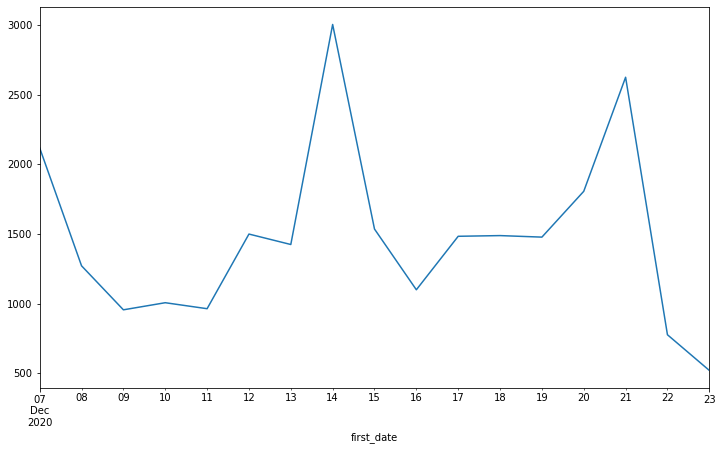

In [762]:
plt.figure(figsize=(12,7))
df_all_a.groupby(['first_date'])['sum'].count().plot()

In [764]:
df_a = pd.pivot_table(
    df_all_a,
    index=['first_date'],
    columns=['event_dt_t0'],
    values='count',
    aggfunc='mean'
)
df_a

event_dt_t0,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,...,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30
first_date,,,,,,,,,,,,,,,,,,,,,
2020-12-07,0.325704,0.312950,0.328358,0.348837,0.379630,0.358696,0.291667,0.421053,0.322034,0.338028,...,0.260870,0.297297,0.379310,0.214286,0.371429,0.321429,0.545455,0.227273,0.312500,0.75
2020-12-08,NaN,0.312676,0.344633,0.307692,0.296296,0.384615,0.384615,0.372549,0.333333,0.444444,...,0.400000,0.521739,0.352941,0.280000,0.583333,0.153846,0.555556,0.461538,0.214286,NaN
2020-12-09,NaN,NaN,0.334601,0.340580,0.361446,0.360000,0.255319,0.416667,0.275862,0.562500,...,0.411765,0.440000,0.428571,0.312500,0.333333,0.090909,0.200000,0.461538,0.368421,NaN
2020-12-10,NaN,NaN,NaN,0.373333,0.400000,0.293478,0.423729,0.352941,0.244444,0.369565,...,0.300000,0.238095,0.133333,0.444444,0.583333,0.333333,0.428571,0.538462,0.111111,NaN
2020-12-11,NaN,NaN,NaN,NaN,0.305455,0.317881,0.294737,0.328358,0.288462,0.333333,...,0.440000,0.440000,0.187500,0.250000,0.428571,0.266667,0.666667,0.400000,0.285714,NaN
2020-12-12,NaN,NaN,NaN,NaN,NaN,0.326531,0.360190,0.340426,0.354839,0.309278,...,0.325000,0.375000,0.216216,0.200000,0.411765,0.285714,0.206897,0.315789,0.352941,NaN
2020-12-13,NaN,NaN,NaN,NaN,NaN,NaN,0.330296,0.311881,0.330882,0.351064,...,0.441860,0.351351,0.325581,0.241379,0.275862,0.314286,0.333333,0.285714,0.428571,NaN
2020-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.342690,0.332584,0.331169,...,0.357143,0.257143,0.380435,0.450000,0.352941,0.393939,0.373134,0.408163,0.232143,NaN
2020-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.338496,0.344037,...,0.258065,0.431373,0.282609,0.215686,0.381818,0.354839,0.309524,0.200000,0.269231,NaN


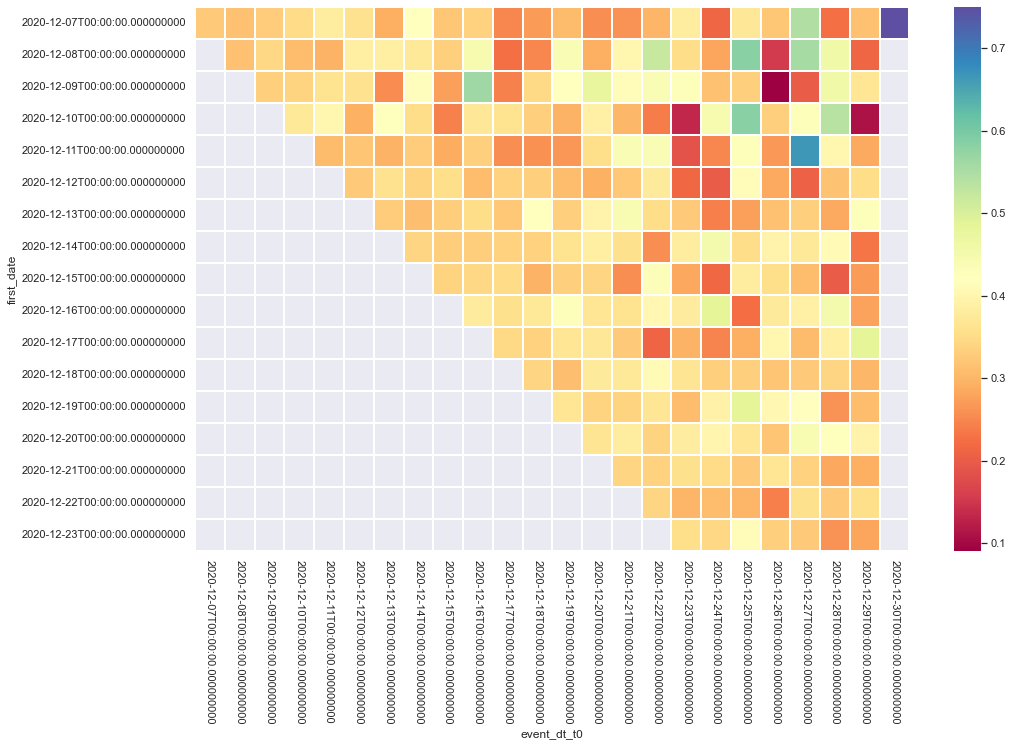

In [776]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (16,10))

sns.set()
ax = sns.heatmap(df_a, cmap="Spectral",  linewidths= .3)
plt.xticks(rotation=-90)

plt.show()